The mathematical form of Bilateral Filter could be expressed as:

$$
I_{p}^{bf} = \frac{1}{W_{p}^{bf}}\sum_{q\in s}G_s(||p-q||_2^2)\cdot {\color{red}G_r(|I_q - I_p|)} \cdot I_q
$$

<span style="color:blue">Some hyper-parameters will be used:</span>
- $s$, the size of the local window;
- $\mu_s$, the mean value of the spatial Gaussian mask;
- $\mu_r$, the mean value of the pxiel range Gaussian mask;
- $var_s$, the variance of the spatial Gaussian mask;
- $var_r$, the variance of the pixel range Gaussian mask;
- $p$, if True, use padding in the boundary areas, default: True;
- $p_type$, the padding type, default: zero padding;

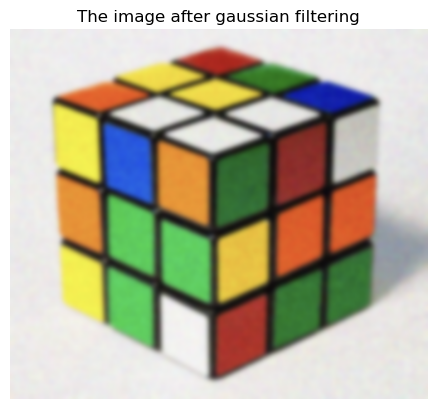

In [4]:
# import some relevant libs
import numpy as np
from PIL import Image
from scipy import ndimage
import cv2
import matplotlib.pyplot as plt

img = np.array(Image.open('./noisy_input.png'), dtype=np.float32)
img_filtered = ndimage.gaussian_filter(img, sigma=[3, 3, 0])

plt.imshow(img_filtered.astype(np.uint8))
plt.axis('off')
plt.title('The image after gaussian filtering')
plt.show()

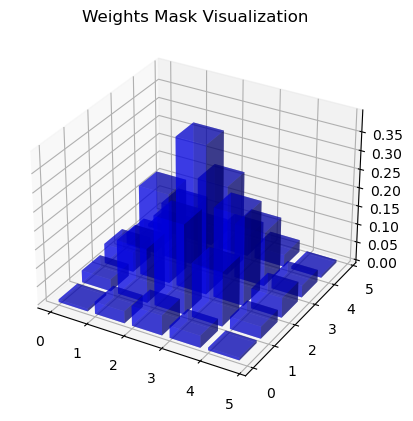

In [ ]:
# Writing our own version of Bilateral Filter by Numpy
# For Loop version (using for loops)
import numpy as np

def get_spatial_local_mask(size=5, std=1.0):
    """Create a spatial convolution mask (spatial gaussian weights).
    Args:
        size (int): Size of the mask (size x size).
        std (float): Standard deviation of the Gaussian function.
    
    Returns:
        spatial_mask (nd.array): Spatial mask.
    """

    assert size > 0 and size % 2 ==1, "Size must be a positive odd int number!"

    # Create a result array
    spatial_mask = np.ones((size, size), dtype=np.float32)
    half_size = size // 2
    x, y = np.meshgrid(np.arange(-half_size, half_size + 1),
                         np.arange(-half_size, half_size + 1),
                         indexing='ij')
    coords = np.stack([x, y], axis=-1)
    
    # Calculate the gaussian weights
    form_term = 1 / np.sqrt(2 * np.pi * std ** 2)
    for i in range(size):
        for j in range(size):
            cur_x, cur_y = coords[i, j]
            spatial_mask[i, j] = form_term * np.exp(-1 * (cur_x ** 2 + cur_y ** 2) / 2.0 / std ** 2)
    
    vis_mask(spatial_mask)

    # TODO: Not Finished yet.
    pass
    
    return spatial_mask


def bilateral_filter(image, size=5, sigma_color=75, sigma_space=1.0, padding=True, padding_type='Zero'):
    """Apply bilateral filter to an image.
    
    Args:
        image (nd.array): the input image;
        size (int): the mask size (size x size);
        sigma_color (float): the standard deviation for color range space;
        sigma_space (float): the standard deviation for spatial space.
        padding (bool): whether to pad the image;
        padding_type (str): the type of padding ('Zero', 'Reflect', 'Edge')
        
    Returns:
        filtered_image (nd.array): the filtered image.
    """

    assert size > 0 and size % 2 == 1, "Size must be a postive odd int number!"
    assert image.shape[0] > size and image.shape[1] > size, "Image must be larger than the mask size!"
    assert sigma_color > 0 and sigma_space > 0, "Sigma values must be positive!"
    half_size = size // 2

    # Pre-process the image
    if padding:
        if padding_type == 'Zero':
            padded_image = np.pad(image, ((half_size, half_size), (half_size, half_size)), mode='constant', constant_values=0)
        elif padding_type == 'Reflect':
            padded_image = np.pad(image, ((half_size, half_size), (half_size, half_size)), mode='reflect')
        elif padding_type == 'Edge':
            padded_image = np.pad(image, ((half_size, half_size), (half_size, half_size)), mode='edge')
        else:
            raise ValueError("Unsupported padding type. Use 'Zero', 'Reflect', or 'Edge'.")
    else:
        raise ValueError('Current nwe only support padding!')

    # Create the spatial mask
    non_normed_spatial_mask = get_spatial_local_mask(size=size, std=sigma_space)



def vis_mask(mask):
    """Visualize the mask by plot 3D bar chart."""
    fig = plt.figure()
    ax = fig.add_subplot(111, projection='3d')
    
    # Create coordinates for the bars
    x_pos = np.arange(mask.shape[0])
    y_pos = np.arange(mask.shape[1])
    x_pos, y_pos = np.meshgrid(x_pos, y_pos)
    x_pos = x_pos.flatten()
    y_pos = y_pos.flatten()
    z_pos = np.zeros_like(x_pos)
    
    # Define width, depth and heights of bars
    dx = dy = 0.8
    dz = mask.flatten()
    
    # Plot bars
    ax.bar3d(x_pos, y_pos, z_pos, dx, dy, dz, color='b', alpha=0.5)
    
    plt.title('Weights Mask Visualization')
    plt.show()


if __name__ == "__main__":
    get_spatial_local_mask(size=5, std=1.0)



7
the shape of spatial kernel: (15, 15)


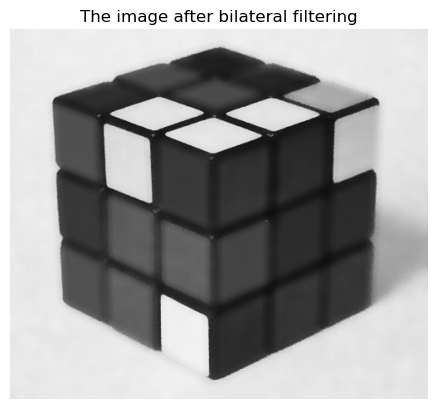

In [25]:
import numpy as np


def bilateral_filter(image, d=15, sigma_color=75, sigma_space=75):
    """Apply bilateral filter to an image.
    
    Args:
        image (nd.array): the input image;
        d (int): diamater of the pixel neighbohood;
        sigma_color (float): the standard deviation for color range space;
        sigma_space (float): the standard deviation for spatial space.
    
    Returns:
        filtered_image (nd.array): the filtered image.
    """

    radius = d // 2
    print(radius)
    filtered_img = np.zeros_like(image, dtype=np.float32)
    padded_img = np.pad(image, ((radius, radius), (radius, radius), (0, 0)), mode='reflect')

    x, y = np.meshgrid(np.arange(-radius, radius + 1), np.arange(-radius, radius + 1))
    spatial_kernel = np.exp(-(x ** 2 + y ** 2) / 2.0 / sigma_space ** 2)
    print(f'the shape of spatial kernel: {spatial_kernel.shape}')

    for i in range(radius, radius + image.shape[0]):
        for j in range(radius, radius + image.shape[1]):
            for k in range(3):
                local_region = padded_img[i - radius : i + radius + 1, j - radius : j + radius + 1, k]
                center_pixel = padded_img[i, j, k]
                color_kernel = np.exp(-((local_region - center_pixel) ** 2) / 2.0 / sigma_color ** 2)

                kernel = spatial_kernel * color_kernel
                kernel_sum = np.sum(kernel)
                normalized_kernel = kernel / kernel_sum
                filtered_pixel = np.sum(normalized_kernel * local_region)
                filtered_img[i - radius, j - radius] = filtered_pixel

    return filtered_img.astype(np.uint8)


if __name__ == "__main__":
    img = np.array(Image.open('./noisy_input.png'), dtype=np.float32)
    img = img[..., 0:3]
    img_filtered = bilateral_filter(img, d=15, sigma_color=75, sigma_space=75)

    plt.imshow(img_filtered)
    plt.axis('off')
    plt.title('The image after bilateral filtering')
    plt.show()

In [ ]:
# RGB version1: Using color vectors to measure the distances
import numpy as np
import cv2

def bilateral_filter_rgb(image, d, sigma_color, sigma_space):
    """
    Applies a bilateral filter to an RGB image using NumPy.

    Parameters:
    - image: The input RGB color image (NumPy ndarray, shape: (height, width, 3)).
    - d: The diameter of the filter kernel.
    - sigma_color: The standard deviation for the color space Gaussian kernel.
    - sigma_space: The standard deviation for the coordinate space Gaussian kernel.

    Returns:
    - filtered_image: The filtered RGB image.
    """
    # Get image dimensions
    height, width, channels = image.shape

    # Create an empty array to store the output image
    filtered_image = np.zeros_like(image, dtype=np.float32)

    # Calculate the kernel radius
    radius = d // 2
    
    # Pad the image edges to handle boundary pixels
    padded_image = np.pad(image, ((radius, radius), (radius, radius), (0, 0)), mode='reflect')

    # 1. Pre-calculate the Spatial Gaussian Kernel (same as the grayscale version)
    x, y = np.meshgrid(np.arange(-radius, radius + 1), np.arange(-radius, radius + 1))
    spatial_dist_sq = x**2 + y**2
    kernel_spatial = np.exp(-spatial_dist_sq / (2 * sigma_space**2))

    # Iterate over each pixel
    for i in range(radius, height + radius):
        for j in range(radius, width + radius):
            # Extract the center pixel's color vector [R, G, B]
            center_pixel_value = padded_image[i, j].astype(np.float32)

            # Extract the neighborhood window, with shape (d, d, 3)
            neighborhood = padded_image[i-radius:i+radius+1, j-radius:j+radius+1].astype(np.float32)
            
            # 2. Calculate the Range (Color) Gaussian Kernel
            # Calculate the squared Euclidean distance of the color vector for each pixel
            # in the neighborhood from the center pixel.
            # `axis=2` sums along the color channels (R,G,B).
            color_diff_sq = np.sum((neighborhood - center_pixel_value)**2, axis=2)
            
            # Calculate the range weight based on the formula
            kernel_range = np.exp(-color_diff_sq / (2 * sigma_color**2))
            
            # 3. Combine the two kernels
            combined_kernel = kernel_spatial * kernel_range
            
            # 4. Normalize the weights
            # wp is a scalar normalization factor
            wp = np.sum(combined_kernel)
            
            # 5. Apply the filter
            # Use broadcasting to apply the (d, d) kernel to the (d, d, 3) neighborhood.
            # combined_kernel[:, :, np.newaxis] expands the kernel from (d,d) to (d,d,1),
            # allowing it to be multiplied element-wise with the (d,d,3) neighborhood.
            weighted_sum = np.sum(neighborhood * combined_kernel[:, :, np.newaxis], axis=(0, 1))
            
            filtered_pixel = weighted_sum / wp
            
            # Store the result in the output image
            filtered_image[i-radius, j-radius] = filtered_pixel

    return filtered_image.astype(np.uint8)


# --- Main execution block ---
if __name__ == '__main__':
    # Read a color image
    # You can replace this with the path to your own image
    try:
        # Try to read 'lena.png' (color version)
        img = cv2.imread('lena.png', cv2.IMREAD_COLOR)
        if img is None:
            raise FileNotFoundError("Image not found or unable to read.")
        # Add some noise to the image to see the filter's effect
        noise = np.random.normal(0, 15, img.shape).astype(np.int16)
        noisy_img = np.clip(img.astype(np.int16) + noise, 0, 255).astype(np.uint8)

    except (FileNotFoundError, AttributeError) as e:
        print(f"'{str(e)}'. A noisy test image will be generated instead.")
        # Create a simple test image
        img = np.zeros((256, 256, 3), dtype=np.uint8)
        img[64:192, 64:192] = [255, 128, 64] # Set a color block
        # Add Gaussian noise
        noise = np.random.normal(0, 25, img.shape).astype(np.int16)
        noisy_img = np.clip(img.astype(np.int16) + noise, 0, 255).astype(np.uint8)

    # Set bilateral filter parameters
    diameter = 15       # Diameter of the filter window
    sigma_color = 50    # Color standard deviation
    sigma_space = 50    # Space standard deviation

    # Apply the custom bilateral filter
    print("Applying custom RGB bilateral filter...")
    denoised_image_custom = bilateral_filter_rgb(noisy_img, diameter, sigma_color, sigma_space)
    print("Done!")
    
    # For comparison, apply OpenCV's built-in bilateral filter
    print("Applying OpenCV's built-in bilateral filter...")
    denoised_image_opencv = cv2.bilateralFilter(noisy_img, diameter, sigma_color, sigma_space)
    print("Done!")

    # Display the results
    cv2.imshow('Original Noisy Image', noisy_img)
    cv2.imshow('Custom RGB Bilateral Filter', denoised_image_custom)
    cv2.imshow('OpenCV Bilateral Filter', denoised_image_opencv)

    # Wait for a key press and then close all windows
    cv2.waitKey(0)
    cv2.destroyAllWindows()

In [ ]:
# RGB version2: Using different channels' single channel bilateral filter
import numpy as np
import cv2

def bilateral_filter(image, d, sigma_color, sigma_space):
    """
    Applies a bilateral filter to a SINGLE-CHANNEL (grayscale) image using NumPy.
    This is a helper function for the channel-wise RGB filter.

    Parameters:
    - image: The input single-channel grayscale image (NumPy ndarray).
    - d: The diameter of the filter kernel.
    - sigma_color: The standard deviation for the color space Gaussian kernel.
    - sigma_space: The standard deviation for the coordinate space Gaussian kernel.

    Returns:
    - filtered_image: The filtered image.
    """
    # Get image dimensions
    height, width = image.shape
    # Create an empty array to store the output image
    filtered_image = np.zeros_like(image, dtype=np.float32)
    # Calculate the kernel radius
    radius = d // 2
    # Pad the image edges to handle boundary pixels
    padded_image = np.pad(image, ((radius, radius), (radius, radius)), mode='reflect')
    # Pre-calculate the Spatial Gaussian Kernel
    x, y = np.meshgrid(np.arange(-radius, radius + 1), np.arange(-radius, radius + 1))
    spatial_dist_sq = x**2 + y**2
    kernel_spatial = np.exp(-spatial_dist_sq / (2 * sigma_space**2))

    # Iterate over each pixel
    for i in range(radius, height + radius):
        for j in range(radius, width + radius):
            # Extract the center pixel value
            center_pixel_value = padded_image[i, j]
            # Extract the neighborhood window
            neighborhood = padded_image[i-radius:i+radius+1, j-radius:j+radius+1]
            # Calculate the Range (Intensity) Gaussian Kernel
            color_diff_sq = (neighborhood - center_pixel_value)**2
            kernel_range = np.exp(-color_diff_sq / (2 * sigma_color**2))
            # Combine the two kernels
            combined_kernel = kernel_spatial * kernel_range
            # Normalize the weights
            wp = np.sum(combined_kernel)
            # Apply the filter
            filtered_pixel = np.sum(combined_kernel * neighborhood) / wp
            # Store the result in the output image
            filtered_image[i-radius, j-radius] = filtered_pixel
            
    return filtered_image.astype(np.uint8)


def bilateral_filter_rgb_channelwise(image, d, sigma_color, sigma_space):
    """
    Applies a bilateral filter to an RGB image by processing each channel independently.

    Parameters:
    - image: The input RGB color image (NumPy ndarray, shape: (height, width, 3)).
    - d: The diameter of the filter kernel.
    - sigma_color: The standard deviation for the color space Gaussian kernel.
    - sigma_space: The standard deviation for the coordinate space Gaussian kernel.

    Returns:
    - filtered_image: The filtered RGB image.
    """
    # Split the image into its B, G, R channels (OpenCV default order)
    b, g, r = cv2.split(image)

    # Apply the grayscale bilateral filter to each channel individually
    print("Filtering Blue channel...")
    b_filtered = bilateral_filter(b, d, sigma_color, sigma_space)
    
    print("Filtering Green channel...")
    g_filtered = bilateral_filter(g, d, sigma_color, sigma_space)

    print("Filtering Red channel...")
    r_filtered = bilateral_filter(r, d, sigma_color, sigma_space)

    # Merge the filtered channels back into an RGB image
    filtered_image = cv2.merge((b_filtered, g_filtered, r_filtered))
    
    return filtered_image

# --- Main execution block ---
if __name__ == '__main__':
    # Read a color image
    try:
        img = cv2.imread('lena.png', cv2.IMREAD_COLOR)
        if img is None:
            raise FileNotFoundError("Image not found or unable to read.")
        # Add some noise to the image
        noise = np.random.normal(0, 15, img.shape).astype(np.int16)
        noisy_img = np.clip(img.astype(np.int16) + noise, 0, 255).astype(np.uint8)

    except (FileNotFoundError, AttributeError) as e:
        print(f"'{str(e)}'. A noisy test image will be generated instead.")
        # Create a simple test image
        img = np.zeros((256, 256, 3), dtype=np.uint8)
        img[64:192, 64:192] = [255, 128, 64] 
        noise = np.random.normal(0, 25, img.shape).astype(np.int16)
        noisy_img = np.clip(img.astype(np.int16) + noise, 0, 255).astype(np.uint8)

    # Set bilateral filter parameters
    diameter = 15       # Diameter of the filter window
    sigma_color = 50    # Color standard deviation
    sigma_space = 50    # Space standard deviation

    # Apply the channel-wise bilateral filter
    print("Applying channel-wise RGB bilateral filter (Method 2)...")
    denoised_image_channelwise = bilateral_filter_rgb_channelwise(noisy_img, diameter, sigma_color, sigma_space)
    print("Done!")
    
    # Display the results
    cv2.imshow('Original Noisy Image', noisy_img)
    cv2.imshow('Channel-wise Bilateral Filter (Method 2)', denoised_image_channelwise)

    # You can also run Method 1 from the previous response to compare
    # from previous_answer import bilateral_filter_rgb 
    # denoised_image_method1 = bilateral_filter_rgb(noisy_img, diameter, sigma_color, sigma_space)
    # cv2.imshow('Color-Space Bilateral Filter (Method 1)', denoised_image_method1)

    # Wait for a key press and then close all windows
    cv2.waitKey(0)
    cv2.destroyAllWindows()